In [70]:
!pip install yfinance
!pip install talib-binary
!pip install python-binance

You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement talib-binary (from versions: none)
ERROR: No matching distribution found for talib-binary
You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.


In [71]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/crypto-prediction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/crypto-prediction")
else:
    repo_path = Path("/home/matias/crypto-prediction")
sys.path.append(str(repo_path))

import pickle
import re
from datetime import datetime, timedelta
from importlib import reload

import get_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import talib
import tensorflow as tf
import wandb
import yfinance as yf
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from tensorflow.keras import layers
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.models import Model
from tools import inspect_code, plotting, training, wandb_api
from tools.training import Datapoint
from tqdm import tqdm
from wandb.keras import WandbCallback

log_wandb = True
tf.config.list_physical_devices("CPU")[0].device_type


'CPU'

In [72]:
wandb_api.login()
api = wandb.Api()
run_name = "1fullt5y"
run = api.run(f"matiasetcheverry/crypto-prediction/{run_name}")
config = run.config

root_path = Path("tmp")
datamodule_script = run.file("datamodule_script.txt")
datamodule_script = datamodule_script.download(root=root_path / run.name, replace=True)
datamodule_script.seek(0)
datamodule_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", datamodule_script.read())[
    0
]
datamodule_script.seek(0)

with open(datamodule_script.name, "r") as file:
    exec(file.read())

model = run.file("rf.pkl")
model = model.download(root=root_path / run.name, replace=True)
with open(model.name, "rb") as file:
    rf = pickle.load(file)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


In [73]:
class DataModule:
    def __init__(
        self,
        config,
        csv_file=None,
        train_df=None,
        test_df=None,
        train_dataset=None,
        validation_dataset=None,
    ):
        super().__init__()
        self.config = config

        if csv_file is not None:
            self.df = pd.read_csv(csv_file, delimiter=";")
            self.df["BEGINNING_DATE"] = pd.to_datetime(
                self.df["BEGINNING_DATE"], dayfirst=True
            )
            self.df["ENDING_DATE"] = pd.to_datetime(
                self.df["ENDING_DATE"], dayfirst=True
            )

        self.train_df = train_df.convert_dtypes() if train_df is not None else None
        self.test_df = test_df.convert_dtypes() if test_df is not None else None
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset

    def _concatenate_indicators(self, data):
        m = list(range(1, 21)) + list(range(40, 241, 20))
        for mi in [0] + m:
            data[f"ir_{mi}"] = data["Close"].shift(mi) / data["Open"].shift(mi) - 1
        for mi in m:
            data[f"cr_{mi}"] = data["Close"].shift(1) / data["Close"].shift(mi + 1) - 1
        for mi in m:
            data[f"or_{mi}"] = data["Open"] / data["Close"].shift(mi) - 1
        data["Direction"] = data["Close"] > data["Open"]
        return data

    def _get_data(
        self,
        ticker=None,
        beginning_date=None,
        ending_date=None,
        interval="12h",
    ):
        try:
            data = get_data.select_data(
                ticker,
                interval,
                beginning_date=beginning_date,
                ending_date=ending_date,
                compute_metrics=self._concatenate_indicators,
                directory="./intraday_rf/",
            )
            return data
        except Exception:
            print(f"Ticker {ticker} could not be downloaded")
            return []

    def setup(self):
        datapoints = []
        for _, row in self.df.iterrows():
            df = self._get_data(
                ticker=row["TICKER"],
                beginning_date=datetime.today() - timedelta(days=400),
                ending_date=datetime.today(),
                interval=self.config["interval"],
            )
            if len(df) > 0:
                data = df.dropna(axis=0)
                df = df.set_index("Datetime")
                data = data.replace(
                    to_replace=[np.inf, -np.inf, np.float64("inf"), -np.float64("inf")],
                    value=0,
                )

                labels = data.pop("Direction").to_numpy()
                dp = training.Datapoint(
                    ticker=row["TICKER"],
                    beginning_date=df.index.min(),
                    ending_date=df.index.max(),
                    df=df,
                    features=data.drop(labels="Datetime", axis=1).to_numpy(),
                    labels=labels,
                )
                if not dp.isempty():
                    datapoints.append(dp)

        test_size = self.config["train_val_test_split"][-1]
        train_size = 1 - self.config["train_val_test_split"][-1]
        n = [int(dp.length * train_size) for dp in datapoints]

        self.test_datapoints = []

        for index, dp in enumerate(datapoints):
            delta = dp.ending_date - dp.beginning_date
            delta_seconds = timedelta(seconds=test_size * delta.total_seconds())
            dp.beginning_date = dp.ending_date - delta_seconds
            dp.features = dp.features[n[index] :]
            dp.labels = dp.labels[n[index] :]
            dp.length = len(dp.features) - n[index]
            print(dp.ticker, dp.features.shape)
            self.test_datapoints.append(dp)

        features = np.concatenate(
            [dp.features[:ni, 6:] for ni, dp in zip(n, datapoints)], axis=0
        )
        labels = np.concatenate(
            [dp.labels[:ni] for ni, dp in zip(n, datapoints)], axis=0
        )

        p = np.random.permutation(len(features))
        features, labels = features[p], labels[p]
        train_size = (
            int(
                config["train_val_test_split"][0]
                / (1 - self.config["train_val_test_split"][-1])
                * len(features)
            )
            if self.config["train_val_test_split"][-1] != 1
            else 0
        )
        self.train_dataset = (features[:train_size], labels[:train_size])
        self.val_dataset = (features[train_size:], labels[train_size:])


config["train_val_test_split"] = [0, 0, 1]
dm = eval(datamodule_name)(config, repo_path / "DATE.csv")
dm.setup()
test_datapoints = dm.test_datapoints
print(len(test_datapoints))


XRP (400, 99)
EOS (400, 99)
BTC (400, 99)
NEO (400, 99)
ALGO (330, 99)
SNX (400, 99)
ETH (400, 99)
AAVE (305, 99)
BNB (400, 99)
BTC (400, 99)
DOT (299, 99)
XTZ (400, 99)
TRX (400, 99)
XRP (400, 99)
ETH (400, 99)
ADA (400, 99)
MATIC (400, 99)
DOGE (400, 99)
KLAY (400, 99)
AVAX (317, 99)
GRT (400, 99)
SAND (354, 99)
SOL (400, 99)
BNB (400, 99)
MANA (400, 99)
ATOM (400, 99)
VET (400, 99)
AVAX (317, 99)
ATOM (400, 99)
FLOKI (22, 99)
MANA (400, 99)
OMG (394, 99)
LUNA (400, 99)
33


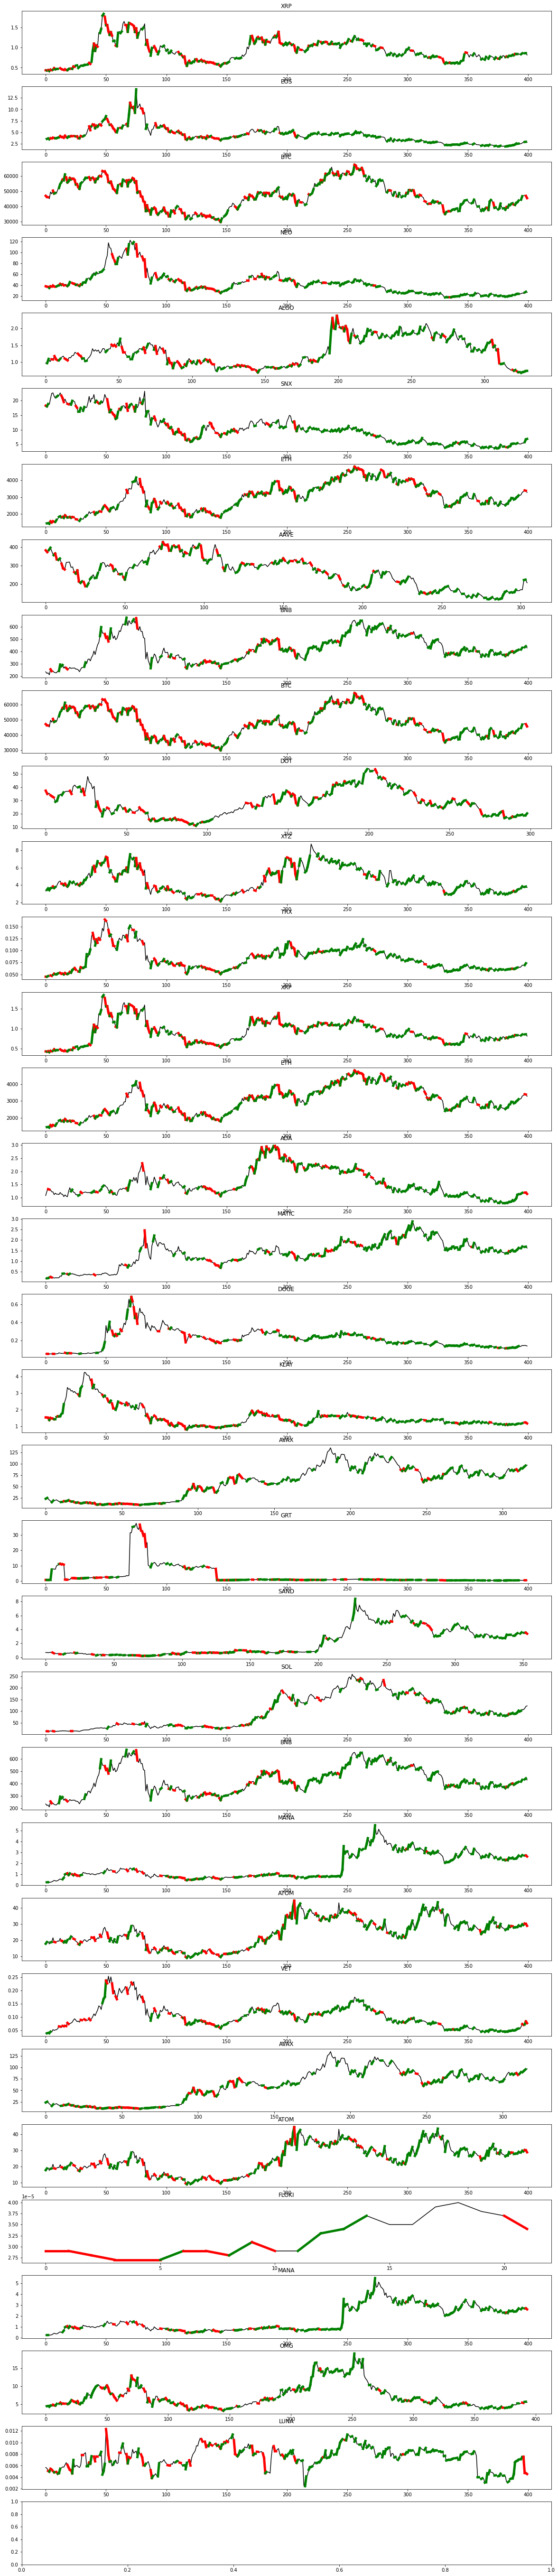

In [74]:
m = len(test_datapoints)
plot = True
metrics = []

if plot:
    fig, axs = plt.subplots(m + 1, figsize=(20, 3 * m))

tf.config.run_functions_eagerly(True)
for index, dp in enumerate(test_datapoints):
    predictions = rf.predict(dp.features[:, 6:])
    dp.recall = recall_score(
        dp.labels.reshape(-1, 1),
        predictions.reshape(-1, 1),
    )
    dp.precision = precision_score(
        dp.labels.reshape(-1, 1),
        predictions.reshape(-1, 1),
        zero_division=0,
    )
    dp.accuracy = accuracy_score(
        dp.labels.reshape(-1, 1),
        predictions.reshape(-1, 1),
    )

    if plot:
        close_idx = 3
        axs[index].plot(dp.features[:, close_idx], color="black")
        for idx, up in enumerate(predictions):
            if up and idx > 0:
                color = (
                    "green"
                    if dp.features[idx - 1, close_idx] < dp.features[idx, close_idx]
                    else "red"
                )
                axs[index].plot(
                    [idx - 1, idx],
                    dp.features[idx - 1 : idx + 1, close_idx],
                    color=color,
                    linewidth=5,
                )
        axs[index].set_title(f"{dp.ticker}")
plt.show()


In [75]:
test_datapoints.sort(key=lambda x: x.precision, reverse=True)
for dp in test_datapoints:
    print(dp.ticker, "\t", dp.precision, "\t", dp.recall)


MANA 	 0.7861635220125787 	 0.628140703517588
MANA 	 0.7861635220125787 	 0.628140703517588
MATIC 	 0.7746478873239436 	 0.5472636815920398
BNB 	 0.7558139534883721 	 0.6190476190476191
BNB 	 0.7558139534883721 	 0.6190476190476191
SNX 	 0.7541899441340782 	 0.678391959798995
XTZ 	 0.7409326424870466 	 0.6941747572815534
TRX 	 0.7366071428571429 	 0.7432432432432432
NEO 	 0.7336683417085427 	 0.6919431279620853
DOGE 	 0.7307692307692307 	 0.59375
VET 	 0.7283236994219653 	 0.586046511627907
ADA 	 0.7277777777777777 	 0.6582914572864321
AVAX 	 0.7243589743589743 	 0.6569767441860465
AVAX 	 0.7243589743589743 	 0.6569767441860465
EOS 	 0.7079207920792079 	 0.7079207920792079
SOL 	 0.7063492063492064 	 0.4218009478672986
LUNA 	 0.7058823529411765 	 0.6346153846153846
OMG 	 0.704225352112676 	 0.7211538461538461
AAVE 	 0.6906474820143885 	 0.6153846153846154
DOT 	 0.6878980891719745 	 0.6835443037974683
GRT 	 0.6820809248554913 	 0.5700483091787439
SAND 	 0.6758620689655173 	 0.56976744186

In [76]:
import vectorbt as vbt

reload(get_data)
from datetime import datetime, timedelta
import vectorbt as vbt

vbt.settings.portfolio["fees"] = 0.001
vbt.settings.portfolio["slippage"] = 0.0025
data = vbt.Data.from_data(
    {dp.ticker: dp.df.drop(labels="Direction", axis=1) for dp in dm.test_datapoints},
    download_kwargs={},
)


/home/matias/.pyenv/versions/3.9.8/envs/binance/lib/python3.9/site-packages/vectorbt/data/base.py:527: UserWarning:

Symbols have mismatching index. Setting missing data points to NaN.



In [81]:
def apply_rf(*args, **kwargs):
    proba = kwargs["proba"]
    price = np.squeeze(np.stack(args[1:], axis=1))
    length = price.shape[0]
    try:
        probabilities = rf.predict_proba(price)
        direction = np.argmax(probabilities > proba, axis=1)
    except ValueError:
        direction = np.zeros(length)
    return direction


def plot_trix(trix, signal, column=None, fig=None):
    fig = trix.vbt.plot(fig=fig)
    fig = signal.vbt.plot(fig=fig)


RF = vbt.IndicatorFactory(
    input_names=list(data.data.values())[0].columns[6:],
    output_names=["direction"],
    # subplots=dict(
    #     plot_outputs=dict(
    #         plot_func=plot_trix,
    #         resolve_trix=True,
    #         resolve_signal=True,
    #     )
    # ),
).from_apply_func(
    apply_rf,
    proba=0.5,
)
direction = RF.run(
    *data.get()[6:],
    run_unique=True,
    short_name="entries",
    per_column=True,
    pass_col=True
)
trend_ma = vbt.MA.run(data.get("Close"), window=50, ewm=True, run_unique=True)

ohlcstcx = vbt.OHLCSTCX.run(
    entries=direction.direction_above(0.5),
    open=data.get("Open"),
    high=data.get("High"),
    low=data.get("Low"),
    close=data.get("Close"),
    sl_stop=0.2,
    sl_trail=False,
    tp_stop=0.3,
)

exits = direction.direction.shift(1).astype('bool') | ohlcstcx.exits
entries = direction.direction


In [82]:
pf = vbt.Portfolio.from_signals(
    data.get("Open"),
    entries=entries,
    exits=exits,
    freq=timedelta(days=1),
)
total_return = pf.total_return()
total_return, total_return[total_return != 0].mean(), total_return[total_return != 0].median()
# for idx, p in enumerate(pf):
#     print(p.returns_stats())
# pf.loc[total_return.idxmax()].plot()
# for p in pf:
#     print(p.returns_stats())
#     print("---------------------------------")


(ohlcstcx_sl_stop  ohlcstcx_sl_trail  ohlcstcx_tp_stop  symbol
 0.2               False              0.3               MANA      138.172444
                                                        MATIC      28.934842
                                                        BNB        18.939538
                                                        SNX        43.624088
                                                        XTZ        20.223858
                                                        TRX        13.699306
                                                        NEO        12.397220
                                                        DOGE        4.094612
                                                        VET        15.889708
                                                        ADA        15.831990
                                                        AVAX        0.000000
                                                        EOS        12.117722
             

In [84]:
# for p in pf:
#     print(p.returns_stats())
#     print("---------------------------------")
pf.iloc[2].plots()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…